<img src="img/Logo_OpenClassrooms.png" width=100 />

# OpenClassrooms Projet 5: Segmentez des clients d'un site e-commerce
# Analyse Exploratoire

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.


# Sommaire
### [Bibliothèques](#1_bibli)
### [Fonctions](#1_funcs)
### [Données](#1_donnees)
### [Création de la base](#1_creation_base)
### [Transformation pour Modélisation](#model)

<a id='1_bibli'></a>
# Import de bibliothèques 📚

In [37]:
import pandas as pd
pd.set_option("mode.chained_assignment", None)
import numpy as np
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import json

<a id='1_funcs'></a>

# Fonctions ⚙️

<a id='get_orders'></a>

In [2]:
def get_orders(client_unique_id):
    """ A partir d'un id client unique la fonction retourne la liste des commandes correspondantes,
    La table des commandes doit au préalable être filtrée en fonction de la date virtuelle de l'étude
    Args:
        client_unique_id
    """
    
    # Avec l'id unique du client on récupère les id clients qui sont liés à chaque commande
    ids_client = customers[customers['customer_unique_id'] == client_unique_id].customer_id.values
    # On peut ensuite récupérer les id des commandes correspondant à ces ids clients
    orders_client = orders[orders.customer_id.isin(ids_client)]
    # On récupère juste les ids
    ids_orders_client = orders_client.index.values
    return ids_orders_client

[Retour au code](#get_orders_back)

<a id='get_nb_days'></a>

In [3]:
def get_nb_days(row, virtual_date, orders):
    """
    Cette fonction calcule le nombre de jours écoulés depuis la première et la dernière 
    commande en prenant pour référence la date virtuelle de l'étude.
    Args :
        row: Pandas DataFrame row (Series) avec un attribut "orders_ids"
        Timestamp 
        Pandas DataFrame : avec les données des commandes
    Returns :
        Tuple
    """
    orders_ids = row.orders_ids
    
    date_first_order = orders.loc[orders_ids[0], 'order_purchase_timestamp']
    date_last_order = orders.loc[orders_ids[-1], 'order_purchase_timestamp']
    
    since_first = (virtual_date - date_first_order).days
    since_last = (virtual_date - date_last_order).days
    return since_first, since_last

[Retour au code](#tps_last_order)

<a id='get_frequency'></a>

In [4]:
def get_frequency(row):
    """
    Calcul du nombre de commandes par mois entre la première commande
    et la date virtuelle.
    """
    return row.nb_orders / row.days_since_first_order * 365.25 / 12

[Retour au code](#frequence)

<a id='get_sum_orders'></a>

In [5]:
def get_sum_orders(row):
    """
    Calcule la somme des montants des commandes
    """
    return order_items[order_items.index.isin(row.orders_ids)].price.sum()    

[Retour au code](#montant)

<a id='get_most_frequent_categ'></a>

In [41]:
def get_most_frequent_categ(row):
    """
    Retourne la catégorie qui revient le plus souvent dans les achats. 
    En cas d'égalité on prend la première donnée par value_counts()
    """
    
    orders_ids = row.orders_ids

    products_ids = order_items[order_items.index.isin(row.orders_ids)].product_id
    products_client = products[products.index.isin(products_ids)]

    try:
        return products_client.product_category_name_english.value_counts().index[0]
    except:
#         print('fail')
        if len(products_client.product_category_name_english.value_counts().index) > 1:
            return products_client.product_category_name_english.value_counts().index[1]
        else :
            return np.nan

[Retour au code](#categorie)

<a id='get_nb_reviews_and_avg'></a>

In [7]:
def get_nb_reviews_and_avg(row):
    """
    Recupère le nombre de reviews et la note moyenne
    """
    orders_ids = row.orders_ids
    client_reviews = reviews[reviews.order_id.isin(orders_ids)]
    if len(client_reviews) > 0:
        return len(client_reviews), client_reviews.review_score.mean()
    else:
        return 0, np.nan

[Retour au code](#reviews)

<a id='get_favourite_payment_method'></a>

In [8]:
def get_favourite_payment_method(row):
    """
    Retourne le type de paiement préféré du client
    """
    orders_ids = row.orders_ids
    payment_methods = payments[payments.order_id.isin(orders_ids)].payment_type.value_counts()
    try:
        return payment_methods.index[0]
    except IndexError:
        return None

[Retour au code](#mode_paiement_prefere)

<a id='get_delivery_time_and_delays'></a>

In [9]:
def get_delivery_time_and_delays(row):
    """
    Pour les clients ayant eu des commandes ayant abouties, on calcule le taux d'avance, de retard et le temps moyen de livraison
    """
    client_orders = orders[orders.index.isin(row.orders_ids)]
    client_orders = client_orders[client_orders.order_status == 'delivered']
    
    if client_orders.shape[0] > 0:
        was_delayed_counts = client_orders.was_delayed.value_counts(normalize=True)
        if True in was_delayed_counts.index:
            delay_rate = was_delayed_counts.loc[True]
        else:
            delay_rate = 0
        was_in_advance_counts = client_orders.was_in_advance.value_counts(normalize=True)
        if True in was_in_advance_counts.index:
            advance_rate = was_in_advance_counts.loc[True]
        else:
            advance_rate = 0
        return client_orders.delivery_time.mean(), delay_rate, advance_rate
    else:
        np.nan, np.nan, np.nan

[Retour au code](#tps_livraison)

<a id='get_cancelation_rate'></a>

In [10]:
def get_cancelation_rate(row):
    client_orders = orders[orders.index.isin(row.orders_ids)]
    status_counts = client_orders.order_status.value_counts(normalize=True)
    if 'canceled' in status_counts.index:
        return status_counts.loc['canceled']
    else:
        return 0

[Retour au code](#annulation)

<a id='1_donnees'></a>

# Données 🎁

<img src="img/structure.png" width=500 />

In [11]:
orders = pd.read_csv('data/olist_orders_dataset.csv', index_col='order_id',parse_dates=['order_purchase_timestamp', 
                                                                                        'order_approved_at',	
                                                                                        'order_delivered_carrier_date',	
                                                                                        'order_delivered_customer_date',
                                                                                        'order_estimated_delivery_date'])
order_items = pd.read_csv('data/olist_order_items_dataset.csv',  index_col='order_id')
products = pd.read_csv('data/olist_products_dataset.csv', index_col='product_id', na_values=np.nan)
customers = pd.read_csv('data/olist_customers_dataset.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
geolocs = pd.read_csv('data/olist_geolocation_dataset.csv')
payments = pd.read_csv('data/olist_order_payments_dataset.csv')
products_categ_traduction = pd.read_csv('data/product_category_name_translation.csv')

Application de la traduction des catégories de produits:

In [12]:
products = products.merge(products_categ_traduction, how='left').set_axis(products.index)

In [13]:
products_categ_traduction.shape[0] == len(products.product_category_name.unique())

False

<a id='1_creation_base'></a>

# Création d'une base répondant au besoin ✅
La base doit avoir pour index les ids des clients avec des variables en relation avec son comportement.

Variables retenues:
- [Nombre de commandes](#nb_commandes)
- [Temps depuis la première et la dernière commande](#tps_last_order)
- [Fréquence achats](#frequence)
- [Montants dépensés](#montant)
- [Catégorie de produit la plus fréquente](#categorie)
- [Nombre d'avis postés et note moyenne](#reviews)
- [Mode de paiement préféré](#mode_paiement_prefere)
- [Temps de livraison et retards](#tps_livraison)
- [Taux d'annulation des commandes](#annulation)

### Important:
Pour le bon fonctionnement du projet, les fonctions développées pour la constitution de la base prendront en paramètre la date à laquelle on veut se fixer virtuellement. En effet on cherchera plus tard dans ce projet à déterminer la fréquence de mise à jour de la base d'entrainement du modèle.
On prendra toujours dans ce notebook la dernière date de la base de donnée.

In [14]:
virtual_date = orders.order_purchase_timestamp.max()

In [15]:
orders.order_purchase_timestamp.max()

Timestamp('2018-10-17 17:30:18')

<a id='nb_commandes'></a>

## Nombre de commandes par client 🥰

Cette variable est la plus importante car va nous permettre de connaitre la taille de notre dataset. En effet, difficile de classer des clients n'ayant fait qu'une commande

Regardons comment fonctionnent les id des clients

In [16]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [17]:
len(customers.customer_unique_id.unique())

96096

In [18]:
len(customers.customer_id.unique())

99441

In [19]:
orders.columns

Index(['customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

On filtre ici la date virtuelle pour garder un trace mais cette commande est neutre

In [20]:
orders = orders[orders.order_purchase_timestamp <= virtual_date]

In [21]:
orders = orders.merge(customers[['customer_id', 'customer_unique_id']], how='left').set_axis(orders.index)

On trie par date pour conserver un ordre des commandes logique

In [22]:
orders.sort_values('order_purchase_timestamp', inplace=True)

In [23]:
(orders.groupby('customer_unique_id').count().customer_id > 1).value_counts()

False    93099
True      2997
Name: customer_id, dtype: int64

### Il n'y a dans la base clients que 2997 clients ayant fait plus d'un commande

In [24]:
data = pd.DataFrame(orders.groupby('customer_unique_id').count().customer_id)

In [25]:
data.columns = ['nb_orders']

In [26]:
data.nb_orders.value_counts().values

array([93099,  2745,   203,    30,     8,     6,     3,     1,     1],
      dtype=int64)

In [27]:
nb_orders_data = data.nb_orders.value_counts()

In [28]:
data.nb_orders.value_counts(normalize=True)

1     0.968812
2     0.028565
3     0.002112
4     0.000312
5     0.000083
6     0.000062
7     0.000031
9     0.000010
17    0.000010
Name: nb_orders, dtype: float64

Text(0.5, 0, 'Nombre de commandes')

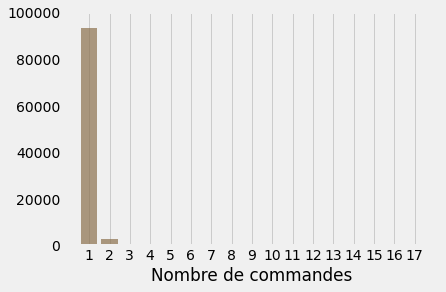

In [29]:
plt.style.use('fivethirtyeight')
plt.bar(nb_orders_data.index,
        nb_orders_data.values,
       color="#8c704d",
       alpha=0.7)
plt.grid(False, axis='y')
plt.xticks(range(1,18))
plt.yticks(np.arange(0, 120e3, 20e3))
plt.xlabel("Nombre de commandes")
# plt.savefig('plots/nb_orders.png',  bbox_inches='tight', dpi=360)

<a id='get_orders_back'></a>
### Pour les autres variables nous avons besoin des ids des commandes correspondant à chaque client

Voir la [fonction](#get_orders)

In [30]:
get_orders.__doc__

" A partir d'un id client unique la fonction retourne la liste des commandes correspondantes,\n    La table des commandes doit au préalable être filtrée en fonction de la date virtuelle de l'étude\n    Args:\n        client_unique_id\n    "

In [31]:
data['orders_ids'] = data.index.map(get_orders)

In [32]:
data.head()

,nb_orders,orders_ids
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,1,[e22acc9c116caa3f2b7121bbb380d08e]
0000b849f77a49e4a4ce2b2a4ca5be3f,1,[3594e05a005ac4d06a72673270ef9ec9]
0000f46a3911fa3c0805444483337064,1,[b33ec3b699337181488304f362a6b734]
0000f6ccb0745a6a4b88665a16c9f078,1,[41272756ecddd9a9ed0180413cc22fb6]
0004aac84e0df4da2b147fca70cf8255,1,[d957021f1127559cd947b62533f484f7]


<a id='frequence'></a>
## Fréquence des commandes
Pour représenter la régularité du client. On se basera aussi sur la date virtuelle

Voir la [fonction](#get_frequency)

La fréquence est exprimée par mois

<a id='montant'></a>
## Montant total des achats 💰

Voir la [fonction](#get_sum_orders)

In [33]:
data['sum_orders'] = data.apply(get_sum_orders, axis=1)

In [34]:
data['sum_orders'].describe()

count    96096.000000
mean       141.438184
std        217.215904
min          0.000000
25%         45.990000
50%         89.000000
75%        154.000000
max      13440.000000
Name: sum_orders, dtype: float64

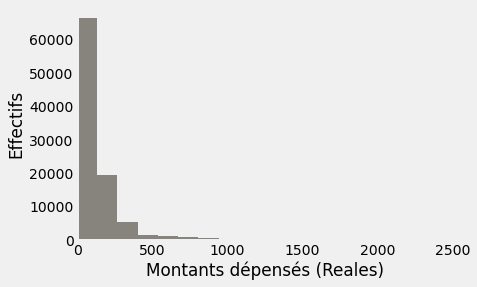

In [35]:
plt.hist(data.sum_orders, 
                       bins=100,
                       color="#59564c",
                       alpha=0.7)
# plt.xticks(np.arange(0,1.1,0.1), rotation=90)
plt.xlim([data.sum_orders.min(),2500])
plt.grid(False, axis='both')
plt.xlabel("Montants dépensés (Reales)")
plt.ylabel("Effectifs")
plt.savefig('plots/montants_v2.png',  bbox_inches='tight', dpi=360)

<a id='categorie'></a>
## Categ préférée
On essaie ici de détecter le type de produit intéressant le plus le client en prenant la catégoie qu'il a le plus acheté

Voir la [fonction](#get_most_frequent_categ)

In [54]:
reduce_cardinality = open("reduce_cardinality.json", "r")
reduce_cardinality = reduce_cardinality.read()
reduce_cardinality = json.loads(reduce_cardinality)

for i in range(4):
    # A faire plusieurs fois pour qu'il soit totalement efficace
    products.product_category_name_english = products.product_category_name_english.replace(reduce_cardinality)
products.product_category_name_english = products.product_category_name_english.fillna('other')

In [55]:
len(products.product_category_name_english.unique())

7

In [56]:
products.product_category_name_english.value_counts()

home                      11281
electronics_auto           5720
health_beauty_fashion      4894
sports_leisure_culture     4553
watches_gifts_toys         3634
pet_baby                   1638
other                      1231
Name: product_category_name_english, dtype: int64

In [57]:
data['favourite_category'] = data.apply(get_most_frequent_categ, axis=1)

In [58]:
data['favourite_category'].value_counts()

home                      29732
electronics_auto          18787
health_beauty_fashion     14733
watches_gifts_toys        12918
sports_leisure_culture    11592
pet_baby                   4514
other                      3144
Name: favourite_category, dtype: int64

Text(0.5, 0, 'Effectifs')

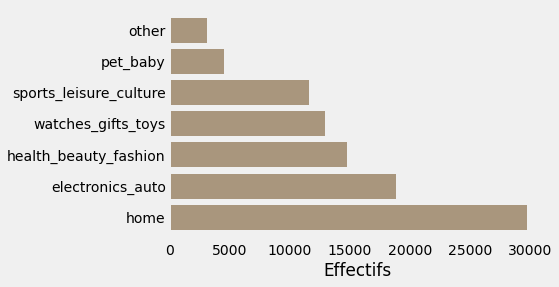

In [61]:
data_bar_categ_fav = data['favourite_category'].value_counts()
plt.barh(data_bar_categ_fav.index,
        data_bar_categ_fav.values,
        color="#8c704d",
        alpha=0.7)
plt.grid(False, axis='both')
plt.xlabel("Effectifs")
# plt.savefig('plots/categ_fav.png',  bbox_inches='tight', dpi=360)

<a id='reviews'></a>
## Nombre d'avis postés et note moyenne⭐
Implication et satisfaction du client sur le site

Voir la [fonction](#get_nb_reviews_and_avg)

In [62]:
data[['nb_reviews', 'average_review_score']] = data.apply(get_nb_reviews_and_avg, axis=1, result_type='expand')

In [63]:
data.nb_reviews.value_counts()

1.0     93015
2.0      2508
3.0       405
4.0       125
5.0        23
6.0        13
7.0         5
17.0        1
9.0         1
Name: nb_reviews, dtype: int64

In [64]:
data.nb_orders.value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: nb_orders, dtype: int64

In [65]:
reviews.review_score.value_counts(normalize=True)

5    0.57420
4    0.19200
1    0.11858
3    0.08287
2    0.03235
Name: review_score, dtype: float64

### C'est louche

In [66]:
data.average_review_score.describe()

count    96096.000000
mean         4.069535
std          1.353446
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: average_review_score, dtype: float64

In [67]:
reviews.review_score.isnull().value_counts()

False    100000
Name: review_score, dtype: int64

On note ici que dans cette base, tous les clients écrivent des reviews et donnent des notes

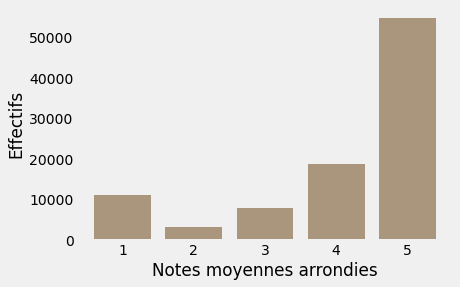

In [68]:
data_bar_reviews_notes = data.average_review_score.round().value_counts()
plt.bar(data_bar_reviews_notes.index,
        data_bar_reviews_notes.values,
        color="#8c704d",
        alpha=0.7)
plt.grid(False, axis='both')
plt.xlabel("Notes moyennes arrondies")
plt.ylabel("Effectifs")
plt.savefig('plots/note_moyenne_v2.png',  bbox_inches='tight', dpi=360)

<a id='mode_paiement_prefere'></a>
## Mode de paiement préféré 💳
Relation du client avec l'argent

Voir la [fonction](#get_favourite_payment_method)

In [69]:
payments.payment_type.value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [70]:
payments.payment_type.isnull().value_counts()

False    103886
Name: payment_type, dtype: int64

In [71]:
data['favourite_payment_type'] = data.apply(get_favourite_payment_method, axis=1).replace('boleto', 'cash')

In [72]:
data['favourite_payment_type'].value_counts()

credit_card    72870
cash           19039
voucher         2701
debit_card      1482
not_defined        3
Name: favourite_payment_type, dtype: int64

In [73]:
data['favourite_payment_type'].replace({'not_defined':'credit_card', 'debit_card':'credit_card'}, inplace=True)

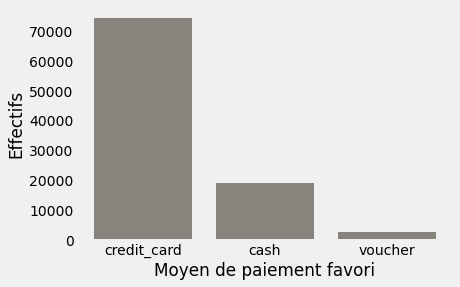

In [75]:
data_bar_payments_notes = data.favourite_payment_type.value_counts()
plt.bar(data_bar_payments_notes.index,
        data_bar_payments_notes.values,
        color="#59564c",
        alpha=0.7)
plt.grid(False, axis='both')
plt.xlabel("Moyen de paiement favori")
plt.ylabel("Effectifs")
plt.savefig('plots/paiements_v2.png',  bbox_inches='tight', dpi=360)

<a id='tps_livraison'></a>
## Temps et retards de livraison 🚚
Expérience logistique du client. pour cette partie nous aurons besoin de créer des variables dans la table "orders"

Nous regarderons le temps moyen de chaque livraison du client et les temps de retard/avance s'il y en a eu

In [76]:
orders['delivery_time'] = orders.order_delivered_customer_date - orders.order_approved_at

In [77]:
orders['delay'] = orders.order_delivered_customer_date - orders.order_estimated_delivery_date

In [78]:
orders['was_delayed'] = orders.delay.map(lambda x : x.days > 1)

In [79]:
orders['was_in_advance'] = orders.delay.map(lambda x : x.days < -1)

Voir la [fonction](#get_delivery_time_and_delays)

In [80]:
data[['average_delivery_time', 'delay_rate', 'advance_rate']] = data.apply(get_delivery_time_and_delays, axis=1, result_type='expand')

In [81]:
data.average_delivery_time.isnull().value_counts()

False    93337
True      2759
Name: average_delivery_time, dtype: int64

In [82]:
data.delay_rate.isnull().value_counts()

False    93358
True      2738
Name: delay_rate, dtype: int64

Pour les retards non renseignés on replit avec 0

Pour les temps de livraisons non renseingés on met la moyenne des temps moyens des autres clients

In [ ]:
data.delay_rate.fillna(0, inplace=True)
data.advance_rate.fillna(0, inplace=True)

In [84]:
data.average_delivery_time.fillna(data.average_delivery_time.mean(), inplace=True)

In [85]:
data.average_delivery_time = data.average_delivery_time.map(lambda x : x.round('d').days)

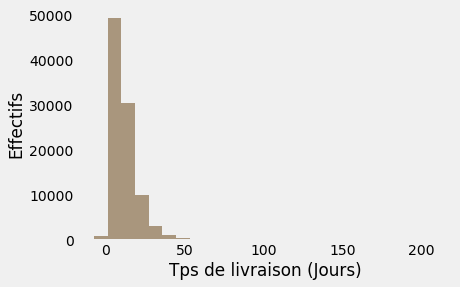

In [86]:
plt.hist(data.average_delivery_time, 
           bins=25,
           color="#8c704d",
           alpha=0.7)

plt.grid(False, axis='both')
plt.xlabel("Tps de livraison (Jours)")
plt.ylabel("Effectifs")
plt.savefig('plots/tps_livraison_v2.png',  bbox_inches='tight', dpi=360)

<a id='annulation'></a>
## Commandes annulées ❌
Capacité du client à aller jusqu'au bout des commandes
Voir la [fonction](#get_cancelation_rate)

<a id='model'></a>
# Transformation pour Modélisation ✔️

In [87]:
data.columns

Index(['nb_orders', 'orders_ids', 'sum_orders', 'favourite_category',
       'nb_reviews', 'average_review_score', 'favourite_payment_type',
       'average_delivery_time', 'delay_rate', 'advance_rate'],
      dtype='object')

In [89]:
data.drop(columns=['orders_ids',
       'favourite_category_english', 'nb_reviews', 'delay_rate', 'advance_rate'], inplace=True, errors="ignore")

### Conversion des données catégoriques en données numériques

In [90]:
data = pd.concat([data, pd.get_dummies(data.favourite_payment_type)], axis=1)

In [92]:
data = pd.concat([data, pd.get_dummies(data.favourite_category)], axis=1)

In [93]:
data.drop(columns=['favourite_payment_type', 'favourite_category'], inplace=True)

In [94]:
data

,nb_orders,sum_orders,average_review_score,average_delivery_time,cash,credit_card,voucher,electronics_auto,health_beauty_fashion,home,other,pet_baby,sports_leisure_culture,watches_gifts_toys
customer_unique_id,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,5.0,6,0,1,0,0,0,1,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,4.0,3,0,1,0,0,1,0,0,0,0,0
0000f46a3911fa3c0805444483337064,1,69.00,3.0,26,0,1,0,0,0,0,0,0,1,0
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,4.0,20,0,1,0,1,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,1,180.00,5.0,13,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,1570.00,5.0,28,0,1,0,0,1,0,0,0,0,0
fffea47cd6d3cc0a88bd621562a9d061,1,64.89,4.0,30,0,1,0,0,0,0,0,1,0,0
ffff371b4d645b6ecea244b27531430a,1,89.90,5.0,15,0,1,0,1,0,0,0,0,0,0


### Suppression des colonnes qui ne sont pas utiles pour la modélisation

In [95]:
data.describe()

,nb_orders,sum_orders,average_review_score,average_delivery_time,cash,credit_card,voucher,electronics_auto,health_beauty_fashion,home,other,pet_baby,sports_leisure_culture,watches_gifts_toys
count,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000
mean,1.034809,141.438184,4.069535,12.125052,0.198125,0.773757,0.028107,0.195502,0.153315,0.309399,0.032717,0.046974,0.120629,0.134428
std,0.214384,217.215904,1.353446,9.382702,0.398589,0.418400,0.165280,0.396589,0.360293,0.462248,0.177897,0.211584,0.325698,0.341113
min,1.000000,0.000000,1.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,45.990000,4.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,89.000000,5.000000,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,154.000000,5.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,17.000000,13440.000000,5.000000,209.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [96]:
data.to_csv('data/customer_data_v_4.csv')